# Plots

In [ ]:
# working on plots because i don't have gpus right now

import numpy as np
import seaborn as sns
import pandas as pd 
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
numpy.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# SEED i: Treatment j 
colors = ['#FF8C00','#1e90ff','#708090']
order = ['CEVAE','DA','Drag.','M3E2']
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [ ]:
!mkdir output

mkdir: cannot create directory ‘output’: File exists


## Functions

In [ ]:
def filter_na_quantile(data):
  print('Previous Shape',data.shape)
  #Drop nan from CEVAE
  data = data.dropna(axis=0)
  print('New Shape after remove NAN',data.shape)
  data.reset_index(inplace=True,drop=True)

  #Drop the top 10 worse results from all methods
  filter_quantile = data.groupby(['Method']).quantile(0.85)['MAE']
  filter_quantile = pd.DataFrame(filter_quantile)
  filter_quantile.reset_index(inplace=True)
  print(filter_quantile)

  drop_rows = []
  for i in range(data.shape[0]):
    th = filter_quantile[filter_quantile['Method']==data['Method'][i]]
    th = th['MAE'].values
    if data['MAE'][i]>= th:
      drop_rows.append(i)
  print(drop_rows)

  data.drop(index=drop_rows,inplace=True)
  print('New shape after removing worse 10%',data.shape)
  return data

def read_all_configs(listfile, fixMAE=False):
  start = ['config1a','config2a']
  for i,config in enumerate(listfile['config'].values): 
    if config in start:
      bd_ = pd.read_csv(path+'output_'+dataname+'_'+config+'.csv').iloc[:, 1:]
      bd_['config'] =  listfile['config'][i]
      bd_['sample_size'] = listfile['sample_size'][i]
      bd_['treatments'] = listfile['treatments'][i]
      bd_['confounders'] = listfile['confounders'][i]
      #if fixMAE:
      #  TrueEffect = bd_[bd_['Method']=='TrueTreat']
      #  TrueEffect.drop(['seed_models'],axis=1, inplace=True)
      #  TrueEffect.drop_duplicates(keep='first', inplace=True)
      #  #bd_['MAE'] = fix_mae_copula(bd_,TrueEffect)
    else: 
      bd_aux = pd.read_csv(path+'output_'+dataname+'_'+config+'.csv').iloc[:, 1:]
      bd_aux['config'] =  listfile['config'][i]
      bd_aux['sample_size'] = listfile['sample_size'][i]
      bd_aux['treatments'] = listfile['treatments'][i]
      bd_aux['confounders'] = listfile['confounders'][i]
      #if fixMAE:
      #  TrueEffect = bd_aux[bd_aux['Method']=='TrueTreat']
      #  TrueEffect.drop(['seed_models'],axis=1, inplace=True)
      #  TrueEffect.drop_duplicates(keep='first', inplace=True)
      # #bd_aux['MAE'] = fix_mae_copula(bd_aux,TrueEffect)
      bd_ = pd.concat([bd_,bd_aux],axis=0)
  bd_.reset_index(drop=True,inplace=True)
  bd_['type'] = 'baseline'
  bd_['type'][bd_['Method']=='M3E2'] = 'proposed'
  bd_=bd_[bd_['Method']!='TrueTreat']
  bd_.reset_index(drop=True,inplace=True)

  bd_['sample_size'] = bd_['sample_size'].astype(str)
  bd_['treatments'] = bd_['treatments'].astype(str)
  bd_['confounders'] = bd_['confounders'].astype(str)
  return bd_

In [ ]:
#GWAS
def plot_treat(data, TrueEffect, ax_, seed,treat, colors, order, title):
  data_ = data[data['seed_data']==seed]
  data_ = data_.set_index('Method').loc[order]
  data_.reset_index(drop=False, inplace=True)
  true = TrueEffect[TrueEffect['seed_data']==seed][treat].values[0]#*(-1) # should I add -1?
  data_[treat] = data_[treat].round(2)
  sns.swarmplot(x="Method", y=treat,
                hue='type', 
                data=data_, 
                palette=sns.color_palette(colors),
                ax=ax_,
                size=9)
  ax_.set_xticklabels(ax_.get_xticklabels())#rotation=90
  ax_.legend([],[], frameon=False)
  ax_.axhline(y=true, color='r', linestyle='-')
  ax_.set_title(title+' τ - '+treat,fontsize=12)
  ax_.set(xlabel='', ylabel='')


In [ ]:
#COPULA
def plot_treat2(data, TrueEffect, ax_, treat, colors, order, title, title2):
  data_ = data.set_index('Method').loc[order]
  data_.reset_index(drop=False, inplace=True)
  TrueEffect.reset_index(drop=True, inplace=True)
  true = TrueEffect[treat][0]*(-1)
  data_[treat] = data_[treat].round(2)
  sns.swarmplot(x="Method", y=treat,
                hue='type', 
                data=data_, 
                palette=sns.color_palette(colors),
                ax=ax_,
                size=7)
  ax_.set_xticklabels(ax_.get_xticklabels())#rotation=90
  ax_.legend([],[], frameon=False)
  ax_.axhline(y=true, color='r', linestyle='-')
  #ax_.set_title(,fontsize=12)
  ax_.set(xlabel=title+' τ'+title2, ylabel='')


## Code


In [ ]:
dataname = 'gwas'
path = '/content/output/'
listfile = pd.read_csv(path+'listfile_exp_'+dataname+'.csv',sep=',',index_col=None)
listfile

,config,sample_size,treatments,confounders
0,config1a,2500,5,995
1,config1b,5000,5,995
2,config1c,10000,5,995
3,config1e,10000,3,1000
4,config1f,10000,6,1000
5,config1g,10000,9,1000
6,config1i,10000,5,100
7,config1j,10000,5,500
8,config1k,10000,5,1000


In [ ]:
#picking config c as the individual plot results 
data = pd.read_csv(path+'output_'+dataname+'_config1f.csv').iloc[:, 1:]
data['Method'] = data['Method'].str.replace("Dragonnet",'Drag.')

data['type'] = 'Baselines'
data['type'][data['Method']=='M3E2'] = 'Proposed'
data.drop(['seed_models'],axis=1, inplace=True)
print(data.head())

TrueEffect = data[data['Method']=='TrueTreat']
TrueEffect.drop_duplicates(keep='first', inplace=True)
print(TrueEffect)

data = data[data['Method']!='TrueTreat']
print(data.groupby(['seed_data','Method']).mean())

data = filter_na_quantile(data)

print(data.groupby(['seed_data','Method']).mean())
print(data.groupby(['Method']).mean())


      Method       MAE   F1_Test  ...        T5  seed_data       type
0         DA  0.247309  0.032283  ...  0.040689          0  Baselines
1      Drag.  0.262882  0.426598  ...  0.049316          0  Baselines
2      CEVAE  0.276878  0.453794  ...  0.019847          0  Baselines
3       M3E2  0.227178  0.623030  ...  0.009681          0   Proposed
4  TrueTreat  0.000000  0.000000  ...  0.244319          0  Baselines

[5 rows x 12 columns]
        Method  MAE  F1_Test  Time(s)  ...        T4        T5  seed_data       type
4    TrueTreat  0.0      0.0      0.0  ... -0.466889  0.244319          0  Baselines
44   TrueTreat  0.0      0.0      0.0  ... -0.216352  0.575385          1  Baselines
84   TrueTreat  0.0      0.0      0.0  ...  0.448359  0.210437          2  Baselines
124  TrueTreat  0.0      0.0      0.0  ...  0.069347  0.088690          3  Baselines

[4 rows x 12 columns]
                       MAE   F1_Test     Time(s)  ...        T3        T4        T5
seed_data Method         

In [ ]:
#LOADING ALL FILES IN ONE DB
dataname = 'gwas'
listfile1 = pd.read_csv(path+'listfile_exp_'+dataname+'.csv',sep=',',index_col=None)
bd_gwas = read_all_configs(listfile1)
bd_gwas['Method'] = bd_gwas['Method'].str.replace("Dragonnet",'Drag.')
bd_gwas = bd_gwas[bd_gwas['Method']!='HiCI']


dataname = 'copula'
listfile2 = pd.read_csv(path+'listfile_exp_'+dataname+'.csv',sep=',',index_col=None)
bd_copula = read_all_configs(listfile2,True)
bd_copula['Method'] = bd_copula['Method'].str.replace("Dragonnet",'Drag.')
bd_copula = bd_copula[bd_copula['Method']!='HiCI']


In [ ]:
#bd_ihdp = pd.read_csv('/content/output/output_ihdp_config3a_filter.csv',index_col=None).iloc[:, 1:]
bd_ihdp = pd.read_csv('/content/output/output_ihdp_config3a.csv',index_col=None).iloc[:, 1:]
bd_ihdp['type'] = 'baseline'
bd_ihdp['type'][bd_ihdp['Method']=='M3E2'] = 'proposed'
bd_ihdp=bd_ihdp[bd_ihdp['Method']!='TrueTreat']
bd_ihdp=bd_ihdp[bd_ihdp['MAE']<1]
bd_ihdp.reset_index(drop=True,inplace=True)
bd_ihdp['Method'] = bd_ihdp['Method'].str.replace("Dragonnet",'Drag.')
bd_ihdp = bd_ihdp[bd_ihdp['seed_data']!=9] 
bd_ihdp.head(10)

,Method,MAE,F1_Test,Time(s),T0,seed_data,seed_models,type
0,DA,0.243268,1.282666,12.899793,3.772799,1,0,baseline
1,Drag.,0.061527,1.022088,7.007396,3.954540,1,0,baseline
2,CEVAE,0.068747,1.117922,25.798882,4.084814,1,0,baseline
3,M3E2,0.126342,1.538697,16.527332,3.889725,1,0,proposed
4,DA,0.111487,1.285212,2.830562,3.904580,1,1,baseline
5,Drag.,0.089949,1.235991,6.218156,3.926118,1,1,baseline
6,CEVAE,0.220623,1.100123,15.092098,4.236690,1,1,baseline
7,M3E2,0.131251,1.413921,16.386999,3.884816,1,1,proposed
8,DA,0.032235,1.299542,3.032752,4.048302,1,2,baseline
9,Drag.,0.108066,1.013818,6.369179,4.124133,1,2,baseline


In [ ]:
bd_ihdp.groupby(['Method']).mean()


,MAE,F1_Test,Time(s),T0,seed_data,seed_models
Method,,,,,,
CEVAE,0.282923,1.304301,15.273913,3.981027,4.937500,3.375000
DA,0.213932,3.266996,2.928092,3.970395,5.042254,3.535211
Drag.,0.153120,1.644684,8.366455,4.044354,5.111111,3.500000
M3E2,0.210522,8.283368,16.209386,3.935712,5.111111,3.500000


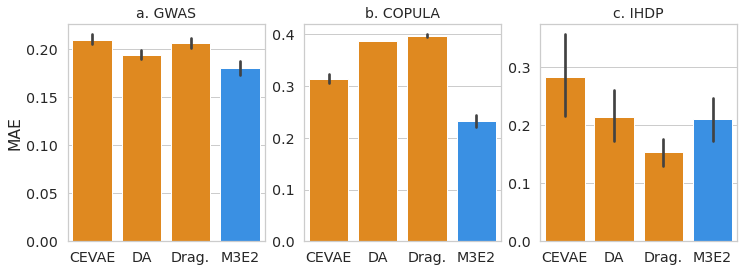

In [ ]:
#Overall
colors = ['#FF8C00','#1e90ff','#708090']
order = ['CEVAE','DA','Drag.','M3E2']
sns.set(font_scale=1.3)
sns.set_style("whitegrid")

fig, ((ax0,ax1, ax2)) = plt.subplots(ncols=3, nrows=1, figsize = [12,4]) #)

#GWAS
sns.barplot(ax=ax0, x=bd_gwas['Method'], y=bd_gwas['MAE'],palette=sns.color_palette(colors),
            hue=bd_gwas['type'],dodge=False, order=order)
ax0.set(xlabel='', ylabel='MAE')
ax0.set_title('a. GWAS',fontsize=14)
ax0.legend([],[], frameon=False)

#COPULA
sns.barplot(ax=ax1, x=bd_copula['Method'], y=bd_copula['MAE'],palette=sns.color_palette(colors),
            hue=bd_copula['type'],dodge=False, order=order)
ax1.set(xlabel='', ylabel='')
ax1.set_title('b. COPULA',fontsize=14)
ax1.legend([],[], frameon=False)
plt.savefig('mae_average.png', dpi=300, bbox_inches='tight')


#IHDP
sns.barplot(ax=ax2, x=bd_ihdp['Method'], y=bd_ihdp['MAE'],palette=sns.color_palette(colors),
            hue=bd_ihdp['type'],dodge=False, order=order)
ax2.set(xlabel='', ylabel='')
ax2.set_title('c. IHDP',fontsize=14)
ax2.legend([],[], frameon=False)
plt.savefig('mae_average.png', dpi=300, bbox_inches='tight')




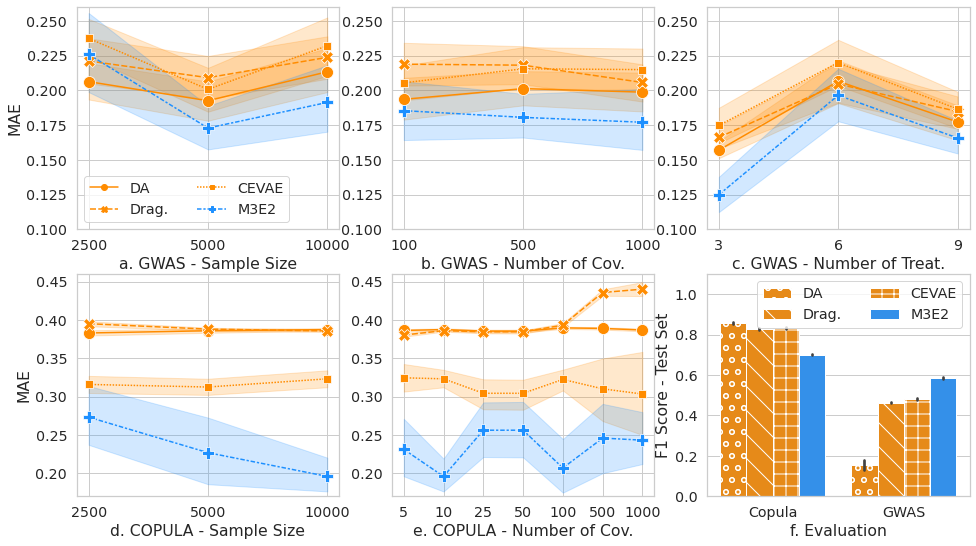

In [ ]:
#plot line - GWAS and copula
colors = ['#FF8C00','#FF8C00', '#FF8C00', '#1e90ff']

fig, ((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(ncols=3, nrows=2, figsize = [16,9]) #)
ymin, ymax = 0.10, 0.26

mysamplesize = ['config1a','config1b','config1c']
bd_gwas_n = bd_gwas[bd_gwas['config'].isin(mysamplesize)]
sns.lineplot(data=bd_gwas_n, x="sample_size", y="MAE",ax=ax0,hue='Method',
             style='Method',markers=True,palette=sns.color_palette(colors),
             legend='brief', markersize=12)
ax0.axis(ymin=ymin,ymax=ymax)
ax0.set(xlabel='a. GWAS - Sample Size')
#ax0.set_title('a. Sample Size',fontsize=14)
ax0.legend(ncol=2)#, colors=sns.color_palette(colors))

mysamplesize = ['config1e','config1f','config1g','config1d']
bd_gwas_t = bd_gwas[bd_gwas['config'].isin(mysamplesize)]
sns.lineplot(data=bd_gwas_t, x="treatments", y="MAE",ax=ax2,hue='Method',
             style='Method',markers=True,palette=sns.color_palette(colors),
             markersize=12)
ax2.axis(ymin=ymin,ymax=ymax)
ax2.set(xlabel='c. GWAS - Number of Treat.',ylabel='')
ax2.legend([],[], frameon=False)
#ax2.set_title('c. Number of Treatments',fontsize=14)

mysamplesize = ['config1i','config1j','config1k']
bd_gwas_c = bd_gwas[bd_gwas['config'].isin(mysamplesize)]
sns.lineplot(data=bd_gwas_c, x="confounders", y="MAE",ax=ax1,hue='Method',
             style='Method',markers=True,palette=sns.color_palette(colors),
             markersize=12)
ax1.axis(ymin=ymin,ymax=ymax)
ax1.set(xlabel='b. GWAS - Number of Cov.',ylabel='')
ax1.legend([],[], frameon=False)
#ax1.set_title('b. Number of Covariates',fontsize=14)

ymin, ymax = 0.17, 0.46

mysamplesize = ['config2a','config2b','config2c']
bd_copula_n = bd_copula[bd_copula['config'].isin(mysamplesize)]
sns.lineplot(data=bd_copula_n, x="sample_size", y="MAE",ax=ax3,hue='Method',
             style='Method',markers=True,palette=sns.color_palette(colors),
             markersize=12)
ax3.axis(ymin=ymin,ymax=ymax)
ax3.set(xlabel='d. COPULA - Sample Size')
ax3.legend([],[], frameon=False)
#ax3.set_title('d. Sample Size',fontsize=14)

#ax3.legend(ncol=2)

mysamplesize = ['config2d','config2e','config2f','config2g','config2h','config2i','config2j']
bd_copula_c = bd_copula[bd_copula['config'].isin(mysamplesize)]
sns.lineplot(data=bd_copula_c, x="confounders", y="MAE",ax=ax4,hue='Method',
             style='Method',markers=True,palette=sns.color_palette(colors),
             markersize=12)
ax4.axis(ymin=ymin,ymax=ymax)
ax4.set(xlabel='e. COPULA - Number of Cov.',ylabel='')
ax4.legend([],[], frameon=False)
#ax4.set_title('e. Number of Covariates',fontsize=14)


bd1 = bd_copula_c[['Method','F1_Test']]
bd2 = bd_gwas_c[['Method','F1_Test']]
bd1['Data'] = 'Copula'
bd2['Data'] = 'GWAS'
bd = pd.concat([bd1,bd2],axis=0)
#bd['F1_Test'] = [1-i if i<0.5 else i for i in bd['F1_Test']]

col = ['#FF8C00','#FF8C00','#FF8C00', '#1e90ff']
col2 = ["#348ABD","#A60628",'#00FF00','#ffffff']
# Make the barplot
ax5 = sns.barplot(data=bd,y='F1_Test',hue='Method',x='Data', palette=sns.color_palette(col),saturation=0.8)
# Define some hatches
hatches = [ 'o','o','\\', '\\','+', '+','','']
# Loop over the bars
for i,thisbar in enumerate(ax5.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
ax5.legend(ncol=2,loc='upper right')
ax5.set(xlabel='f. Evaluation',ylabel='F1 Score - Test Set')
ax5.axis(ymin=0,ymax=1.1)

plt.savefig('mae_6lines.png', dpi=300, bbox_inches='tight')

In [ ]:
#picking config c as the individual plot results 
dataname2 = 'copula'
data = pd.read_csv(path+'output_'+dataname2+'_config2c.csv').iloc[:, 1:]
data['Method'] = data['Method'].str.replace("Dragonnet",'Drag.')
data['type'] = 'Baselines'
data['type'][data['Method']=='M3E2'] = 'Proposed'
data.drop(['seed_models','seed_data'],axis=1, inplace=True)
print(data.head())

TrueEffect = data[data['Method']=='TrueTreat']
TrueEffect.drop_duplicates(keep='first', inplace=True)
print(TrueEffect)

data = data[data['Method']!='TrueTreat']
print(data.groupby(['Method']).mean())

#data['MAE'] = fix_mae_copula(data,TrueEffect)
data.head(10)

      Method       MAE   F1_Test  ...        T2        T3       type
0         DA  0.385275  0.892326  ...  0.006577  0.004093  Baselines
1      Drag.  0.374803  0.858642  ...  0.011506  0.001302  Baselines
2      CEVAE  0.290082  0.859263  ... -0.085327  0.044908  Baselines
3       M3E2  0.174536  0.699091  ... -0.105548  0.265864   Proposed
4  TrueTreat  0.796330  0.000000  ...  0.205505 -0.102752  Baselines

[5 rows x 9 columns]
      Method      MAE  F1_Test  ...        T2        T3       type
4  TrueTreat  0.79633      0.0  ...  0.205505 -0.102752  Baselines

[1 rows x 9 columns]
             MAE   F1_Test     Time(s)        T0        T1        T2        T3
Method                                                                        
CEVAE   0.323214  0.856534  287.282065  0.190370  0.041352 -0.071104  0.024317
DA      0.387447  0.889460    9.259573  0.063658 -0.019873  0.000388 -0.000526
Drag.   0.385687  0.854537  147.583485  0.101721 -0.030626  0.019175 -0.002009
M3E2    0.195

,Method,MAE,F1_Test,Time(s),T0,T1,T2,T3,type
0,DA,0.385275,0.892326,46.060802,0.075222,-0.021178,0.006577,0.004093,Baselines
1,Drag.,0.374803,0.858642,170.307581,0.131027,-0.027374,0.011506,0.001302,Baselines
2,CEVAE,0.290082,0.859263,312.004957,0.232198,0.069901,-0.085327,0.044908,Baselines
3,M3E2,0.174536,0.699091,95.388192,0.989446,0.653882,-0.105548,0.265864,Proposed
5,DA,0.391217,0.889846,8.275502,0.039680,-0.011707,0.007125,0.006944,Baselines
6,Drag.,0.386015,0.856138,158.707366,0.088760,-0.022389,0.005782,-0.011990,Baselines
7,CEVAE,0.392930,0.857098,258.990185,0.142376,0.043943,NaN,0.022047,Baselines
8,M3E2,0.201606,0.683636,97.030222,1.253257,0.585843,-0.235593,0.324390,Proposed
10,DA,0.393773,0.887433,7.876180,0.040991,-0.025669,0.005954,0.008199,Baselines
11,Drag.,0.382302,0.854751,154.082464,0.092191,-0.024920,0.010117,0.006298,Baselines


Previous Shape (128, 9)
New Shape after remove NAN (123, 9)
  Method       MAE
0  CEVAE  0.341071
1     DA  0.392173
2  Drag.  0.390107
3   M3E2  0.238030
[7, 11, 14, 32, 33, 44, 45, 46, 50, 51, 52, 56, 58, 63, 76, 98, 99, 107, 117]
New shape after removing worse 10% (104, 9)


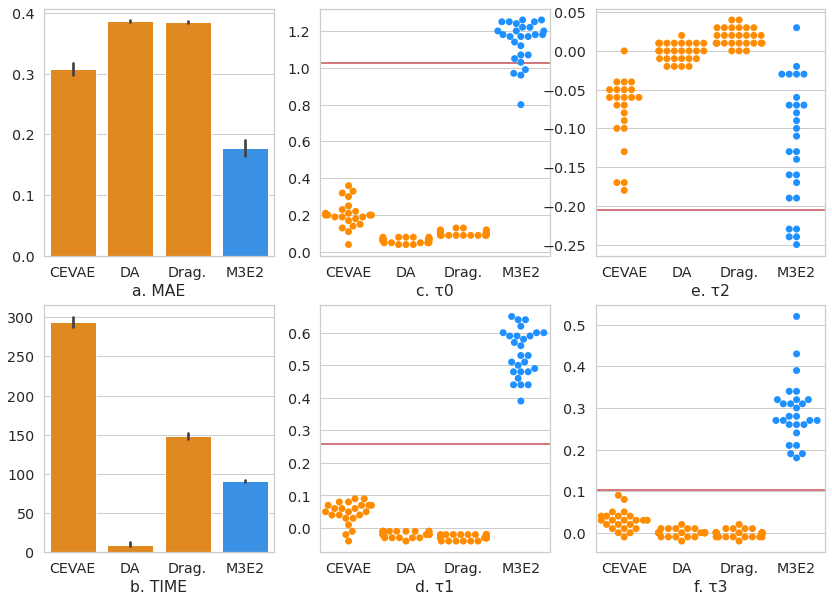

In [ ]:
colors = ['#FF8C00','#1e90ff','#708090']
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(ncols=3, nrows=2, figsize = [14,10]) #)

data_ = filter_na_quantile(data)

plot_treat2(data_, TrueEffect, ax1,'T0', colors,order, 'c.','0')
plot_treat2(data_, TrueEffect, ax4, 'T1', colors,order, 'd.','1')
plot_treat2(data_, TrueEffect, ax2,'T2', colors,order, 'e.','2')
plot_treat2(data_, TrueEffect, ax5, 'T3', colors,order, 'f.','3')

#Last Plot
sns.barplot(ax=ax0, x=data_['Method'], y=data_['MAE'],palette=sns.color_palette(colors),
            hue=data_['type'],dodge=False, order =order)
ax0.set(xlabel='a. MAE', ylabel='')
#ax0.set_title('a. MAE',fontsize=12)
ax0.legend([],[], frameon=False)

sns.barplot(ax=ax3, x=data_['Method'], y=data_['Time(s)'],palette=sns.color_palette(colors),
            hue=data_['type'],dodge=False, order =order)
ax3.set(xlabel='b. TIME', ylabel='')
#ax3.set_title('b. TIME',fontsize=12)
ax3.legend([],[], frameon=False)


plt.savefig('mae_6plots.png', dpi=300, bbox_inches='tight')